# Tutorial for STARmap V1C dataset
Need additional packages: scanpy seaborn networkx

### Load the packages

In [ ]:
import os
import time
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, f1_score

from Harmonics import *

import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=50, dpi_save=500)

from matplotlib import rcParams
rcParams["figure.dpi"] = 50
rcParams["savefig.dpi"] = 500

### Specify the data and save path

In [2]:
data_dir = '../../../Data/Spatial/Transcriptomics/STARmap_V1_Wang2018/'
save_dir = f'../../results/STARmap_V1_Wang2018/Harmonics/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Define a function to match the niche label to ground truth annotation and a function to change p values to corresponding star representation, used to show the results of additional tests implemented in Harmonics.

In [3]:
import numpy as np
import pandas as pd
import networkx as nx

def match_cluster_labels(true_labels, est_labels):
    true_labels_arr = np.array(list(true_labels))
    est_labels_arr = np.array(list(est_labels))

    org_cat = list(np.sort(list(pd.unique(true_labels))))
    est_cat = list(np.sort(list(pd.unique(est_labels))))

    B = nx.Graph()
    B.add_nodes_from([i + 1 for i in range(len(org_cat))], bipartite=0)
    B.add_nodes_from([-j - 1 for j in range(len(est_cat))], bipartite=1)

    for i in range(len(org_cat)):
        for j in range(len(est_cat)):
            weight = np.sum((true_labels_arr == org_cat[i]) * (est_labels_arr == est_cat[j]))
            B.add_edge(i + 1, -j - 1, weight=-weight)

    match = nx.algorithms.bipartite.matching.minimum_weight_full_matching(B)

    if len(org_cat) >= len(est_cat):
        return np.array([match[-est_cat.index(c) - 1] - 1 for c in est_labels_arr])
    else:
        unmatched = [c for c in est_cat if not (-est_cat.index(c) - 1) in match.keys()]
        l = []
        for c in est_labels_arr:
            if (-est_cat.index(c) - 1) in match:
                l.append(match[-est_cat.index(c) - 1] - 1)
            else:
                l.append(len(org_cat) + unmatched.index(c))
        return np.array(l)
    
    
def p2stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

### Load dataset

In [4]:
slice_name_list = ['V1']
adata = ad.read_h5ad(data_dir + 'processed/STARmap_V1Cortex.h5ad')
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'clusterid', 'celltype', 'layer'
    obsm: 'spatial'

In [5]:
adata.obs['celltype'].value_counts()

celltype
eL4        189
eL2/3      176
eL6-2      156
Oligo      154
Astro-2    105
Endo        86
eL6-1       80
eL5         69
Micro       52
PVALB       31
Reln        27
Astro-1     26
SST         23
VIP         13
HPC         10
Smc         10
Name: count, dtype: int64

### Filtered out the smooth muscle cells, focusing only on the cortex layer

In [6]:
adata = adata[~(adata.obs['celltype'] == 'Smc'), :].copy()
adata

AnnData object with n_obs × n_vars = 1197 × 1020
    obs: 'clusterid', 'celltype', 'layer'
    obsm: 'spatial'

### Run model

Instantiate Harmonics

In [ ]:
iter=0
model = Harmonics_Model(adata,  # anndata object with cell type and spatial coordinates information
                        slice_name_list,  # list of slice names (only one slice here)
                        concat_label='slice_name',  # the label in .obs to store slice names
                        seed=1234+iter,  # default
                        parallel=False,  # recommand to set to True for large dataset and False for small dataset
                        verbose=True,  # default
                        )

Dataset comprises 1 slices, 1197 cells/spots in total.


Preprocess the data (Generating the connection graph and calculating neighborhood cell type destribution for cells)

In [8]:
model.preprocess(ct_key='celltype',  # default
                 spatial_key='spatial',  # default
                 method='joint',  # default
                 n_step=3,  # default
                 n_neighbors=20,  # default
                 cut_percentage=99,  # default
                 )

Generating Delaunay neighbor graph...


100%|██████████| 1/1 [00:00<00:00, 61.64it/s]


All done!

Performing graph completion...


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


All done!

The cell types of interest are:
Astro-1
Astro-2
Endo
HPC
Micro
Oligo
PVALB
Reln
SST
VIP
eL2/3
eL4
eL5
eL6-1
eL6-2

Generating one-hot matrix...


100%|██████████| 1/1 [00:00<00:00, 332.33it/s]

All done!

Dataset comprises 15 cell types.

Calculating cell type distribution for microenvironments...
Microenvironments comprise 39.93 cells/spots on average. 
Minimum: 20, Maximum: 61



Perform overclustered initialization on the cell type distributions of cell neighborhoods. Resulting in *Qmax* niches. The distributions of niches are also computed. We set *Qmax* to 10 since this is a relatively small dataset.

In [ ]:
model.initialize_clusters(dim_reduction=True,  # default
                          explained_var=None,  # default
                          n_components=None,  # default
                          n_components_max=100,  # default
                          standardize=True,  # default
                          method='kmeans',  # default 
                          Qmax=10, 
                          )

Performing dimension reduction...
Returning 15 principal components.

Initializing niches...
10 initial niches defined.



Perform hierarchical distribution matching to reduce the niche number to no more than *Qmin*. This step results in niche assignment under a sequence of different niche numbers (usually from *Qmax* to *Qmin*).

In [ ]:
model.hier_dist_match(assign_metric='jsd',  # default
                      weighted_merge=True,  # default
                      max_iters=100,  # default 
                      tol=1e-4,  # default 
                      test_kmeans=False,  # default
                      Qmin=2,  # default
                      )

Starting from 10 cell niches...

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


 62%|██████▏   | 62/100 [00:00<00:00, 212.14it/s]


Early stop because of duplicate reassignment at iteration 63.
9 cell niches left.
Merging cell niche 5 and cell niche 6...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 5, 7, 8, 9]


  3%|▎         | 3/100 [00:00<00:00, 186.90it/s]


Strictly converge at iteration 4.
8 cell niches left.
Merging cell niche 1 and cell niche 8...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 5, 7, 9]


  2%|▏         | 2/100 [00:00<00:00, 177.27it/s]


Strictly converge at iteration 3.
7 cell niches left.
Merging cell niche 1 and cell niche 0...
Done!

Assigning cells to cell niche...
Current state: [1, 2, 3, 5, 7, 9]


  9%|▉         | 9/100 [00:00<00:00, 187.22it/s]


Strictly converge at iteration 10.
6 cell niches left.
Merging cell niche 5 and cell niche 2...
Done!

Assigning cells to cell niche...
Current state: [1, 3, 5, 7, 9]


  2%|▏         | 2/100 [00:00<00:00, 150.53it/s]


Strictly converge at iteration 3.
5 cell niches left.
Merging cell niche 7 and cell niche 1...
Done!

Assigning cells to cell niche...
Current state: [3, 5, 7, 9]


 11%|█         | 11/100 [00:00<00:00, 352.56it/s]


Strictly converge at iteration 12.
4 cell niches left.
Merging cell niche 5 and cell niche 3...
Done!

Assigning cells to cell niche...
Current state: [5, 7, 9]


  0%|          | 0/100 [00:00<?, ?it/s]

Strictly converge at iteration 18.

 17%|█▋        | 17/100 [00:00<00:00, 510.61it/s]



3 cell niches left.
Merging cell niche 7 and cell niche 9...
Done!

Assigning cells to cell niche...
Current state: [5, 7]


  6%|▌         | 6/100 [00:00<00:00, 125.44it/s]

Strictly converge at iteration 7.
2 cell niches left.
Niche count no more than 2.

Finished!



Select the solution by seting the *n_niche* to 7 to match the number of niches from expert annotations. The results of niche assignments are saved in .obs[niche_key]

In [11]:
adata_list, adata_concat = model.select_solution(n_niche=7, 
                                                 niche_key='niche_label',  # default 
                                                 auto=False, 
                                                 metric='jsd',  # default
                                                 threshold=0.1,  # default
                                                 return_adata=True,  # default
                                                 plot=True,  # default
                                                 save=False,  # default
                                                 fig_size=None,  # default
                                                 save_dir=save_dir, 
                                                 file_name=f'score_vs_nichecount_basic_{iter}.pdf',
                                                 )

Selecting solution based on specified niche count...
Done!



Save and reload the results

In [ ]:
adata_concat.write_h5ad(save_dir + f'Harmonics_result_{iter}.h5ad')

In [ ]:
adata_concat = ad.read_h5ad(save_dir + f'Harmonics_result_{iter}.h5ad')
adata_new = adata_concat.copy()
adata_new

AnnData object with n_obs × n_vars = 1197 × 1020
    obs: 'clusterid', 'celltype', 'layer', 'slice_name', 'celltype_idx', 'n_neighbors', 'niche_label'
    uns: 'ct2idx', 'idx2ct', 'niche_cell_count', 'niche_dist', 'niche_label_summary'
    obsm: 'micro_dist', 'onehot', 'spatial'

### Plot the results and calculate scores

ARI:  0.6616, AMI:  0.7249, mF1:  0.8278, wF1:  0.8321


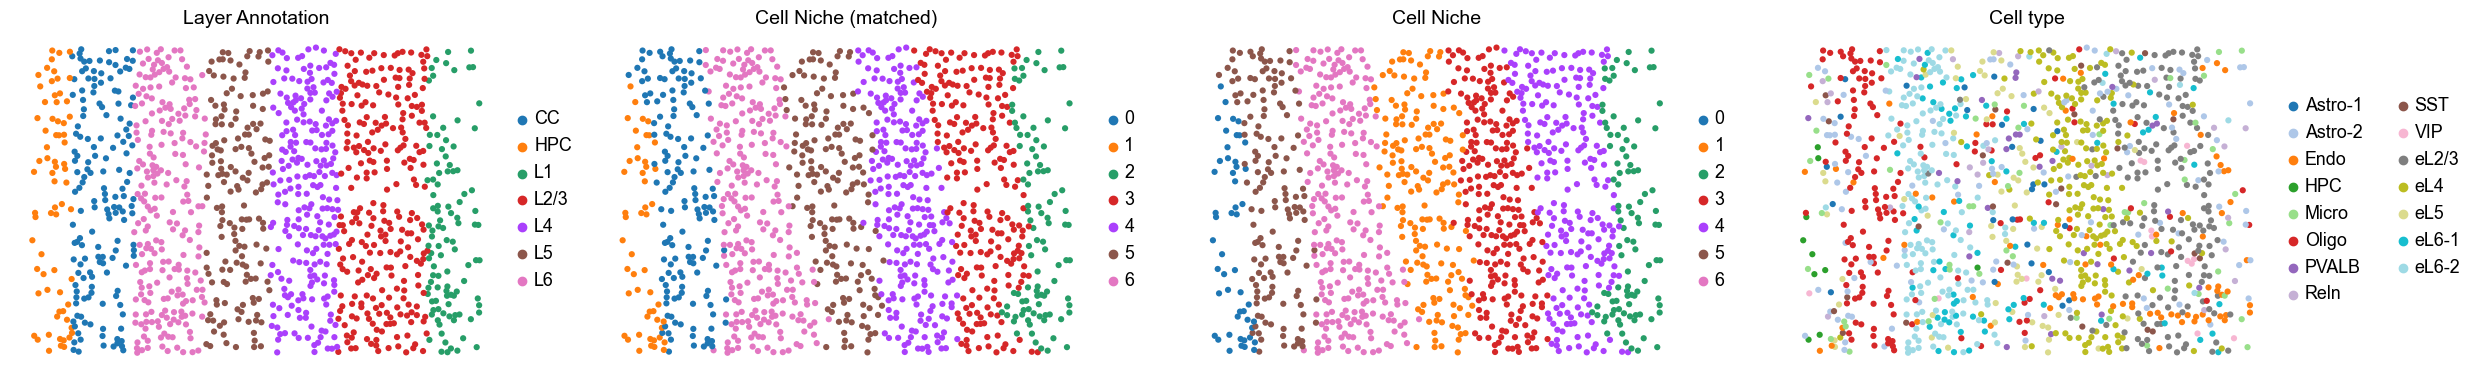

In [ ]:
layers = sorted(set(adata_new.obs['layer']))
layer_color_dict = {layers[k]: sns.color_palette()[k] for k in range(len(layers))}

niches = sorted(set(adata_new.obs['niche_label']))
niche_color_dict = {niches[k]: sns.color_palette()[k] for k in range(len(niches))}

celltypes = ['Astro-1', 'Astro-2', 'Endo', 'HPC', 'Micro', 'Oligo', 'PVALB', 'Reln', 
             'SST', 'Smc', 'VIP', 'eL2/3', 'eL4', 'eL5', 'eL6-1', 'eL6-2']
ct_colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#2ca02c', '#98df8a', '#d62728', '#9467bd', '#c5b0d5',
             '#8c564b', '#e377c2', '#f7b6d2', '#7f7f7f', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
ct_color_dict = {celltypes[k]: ct_colors[k] for k in range(len(celltypes))}


# Match the niche assignment label to the experts annotations
matched_clusters = match_cluster_labels(adata_new.obs['layer'], adata_new.obs[f'niche_label'])
matched_labels = [layers[idx] if idx < len(layers) else 'Unmatched' for idx in matched_clusters]
adata_new.obs[f'matched_cluster'] = [str(label) for label in matched_clusters]
adata_new.obs[f'matched_label'] = matched_labels

ari = adjusted_rand_score(adata_new.obs['layer'], matched_clusters)
ami = adjusted_mutual_info_score(adata_new.obs['layer'], matched_clusters)
f1_macro = f1_score(adata_new.obs['layer'], matched_labels, average='macro')
f1_weighted = f1_score(adata_new.obs['layer'], matched_labels, average='weighted')
print(f"ARI: {ari: .4f}, AMI: {ami: .4f}, mF1: {f1_macro: .4f}, wF1: {f1_weighted: .4f}")


fig, axes = plt.subplots(1, 4, figsize=(25, 4))

sc.pl.embedding(adata_new, basis='spatial', palette=layer_color_dict, color='layer', 
                ax=axes[0], s=80, show=False, frameon=False, title='Layer Annotation')

sc.pl.embedding(adata_new, basis='spatial', palette=niche_color_dict, color='matched_cluster', 
                ax=axes[1], s=80, show=False, frameon=False, title='Cell Niche (matched)')

sc.pl.embedding(adata_new, basis='spatial', palette=niche_color_dict, color='niche_label', 
                ax=axes[2], s=80, show=False, frameon=False, title='Cell Niche')

sc.pl.embedding(adata_new, basis='spatial', palette=ct_color_dict, color='celltype', 
                ax=axes[3], s=80, show=False, frameon=False, title='Cell type')

plt.tight_layout()
plt.show()

### Cell type enrichment analysis

In [14]:
ct_df = ct_enrichment_test(adata_new.uns['niche_dist'], 
                           adata_new.uns['niche_cell_count'], 
                           adata_new.uns['idx2ct'],
                           adata_new.uns['niche_label_summary'],
                           method='fisher', 
                           alpha=0.05, 
                           fdr_method='fdr_by', 
                           log2fc_threshold=1,
                           prop_threshold=0.01,
                           verbose=True,
                           )
ct_df.head()

7 niches and 15 cell types in total.



,niche_idx,niche,celltype_idx,celltype,oddsratio,p-value,q-value,log2fc,prop,enrichment
0,0,0,0,Astro-1,3.119334,9.075600e-02,8.602616e-01,1.581194,0.06,False
1,0,0,1,Astro-2,2.403201,3.476422e-02,3.675465e-01,1.104756,0.18,False
2,0,0,2,Endo,1.480556,3.948701e-01,1.000000e+00,0.501872,0.10,False
3,0,0,3,HPC,251.560976,1.799649e-12,8.994524e-11,7.689718,0.18,True
4,0,0,4,Micro,3.263834,1.827748e-02,2.137970e-01,1.581194,0.12,False


Plot the results

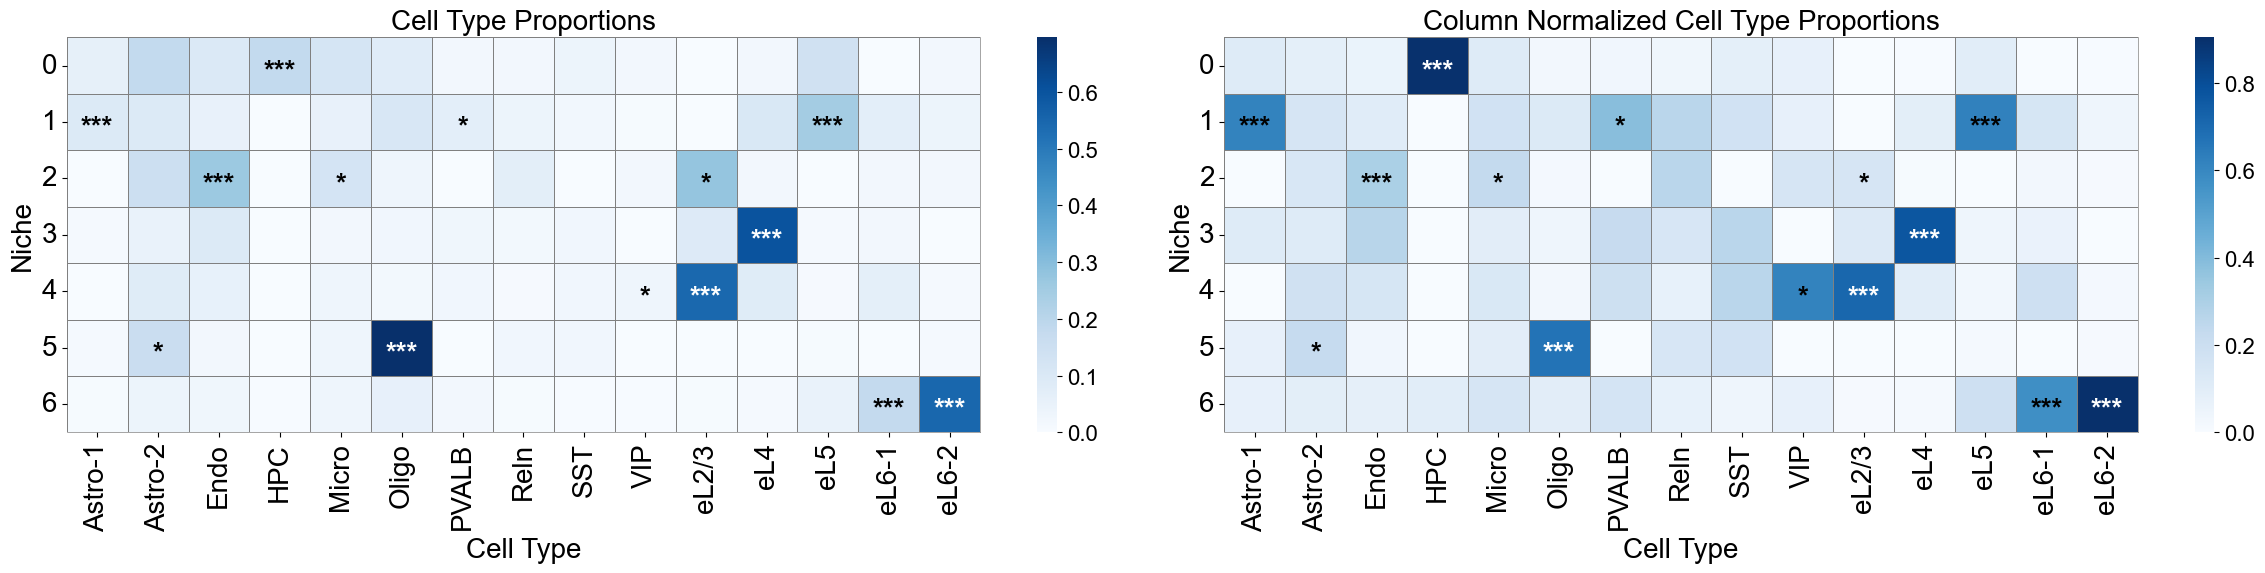

In [13]:
niche_labels = adata_new.uns['niche_label_summary'].copy()
ct_labels = sorted(adata_new.obs['celltype'].unique())

matrix_df = pd.DataFrame(
    data=adata_new.uns['niche_dist'].toarray(),
    index=niche_labels,
    columns=ct_labels,
)

cn_dist_count = adata_new.uns['niche_dist'].toarray() * adata_new.uns['niche_cell_count'][:, np.newaxis]
cn_dist_norm = cn_dist_count / np.sum(cn_dist_count, axis=0)
matrix_df_norm = pd.DataFrame(
    data=cn_dist_norm,
    index=niche_labels,
    columns=ct_labels,
)

ct_df['stars'] = ct_df['q-value'].apply(p2stars)

stars_df = pd.DataFrame(
    '', 
    index=matrix_df.index, 
    columns=matrix_df.columns
)

for _, row in ct_df[ct_df['enrichment']].iterrows():
    niche = row['niche']
    ct    = row['celltype']
    if (niche in stars_df.index) and (ct in stars_df.columns):
        stars_df.loc[niche, ct] = row['stars']


fig, axes = plt.subplots(1, 2, figsize=(24, 6))

sns_heatmap_0 = sns.heatmap(
    matrix_df, 
    cmap='Blues', 
    # cbar_kws={'label': 'Cell type proportion'}, 
    linewidths=0.5,
    linecolor='gray',
    # square=True,
    ax=axes[0]
)

for i, niche in enumerate(matrix_df.index):
    for j, ct in enumerate(matrix_df.columns):
        star = stars_df.iloc[i, j]
        if star:
            if matrix_df.iloc[i, j] > np.max(matrix_df.values) * 0.7:
                color='white'
            else:
                color='black'
            axes[0].text(j + 0.5, i + 0.6, star, ha='center', va='center', color=color, fontsize=20, fontweight='bold')
            if matrix_df_norm.iloc[i, j] > np.max(matrix_df_norm.values) * 0.7:
                color='white'
            else:
                color='black'
            axes[1].text(j + 0.5, i + 0.6, star, ha='center', va='center', color=color, fontsize=20, fontweight='bold')

n_rows, n_cols = matrix_df.shape
axes[0].plot([0, n_cols], [n_rows, n_rows], color='gray', linewidth=0.5, clip_on=False) 
axes[0].plot([n_cols, n_cols], [0, n_rows], color='gray', linewidth=0.5, clip_on=False)  

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center', fontsize=20)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, ha='right', fontsize=20)
axes[0].set_ylabel('Niche', fontsize=20)
axes[0].set_xlabel('Cell Type', fontsize=20)
axes[0].set_title('Cell Type Proportions', fontsize=20)
axes[0].collections[0].colorbar.ax.yaxis.label.set_size(20)
axes[0].collections[0].colorbar.ax.tick_params(labelsize=16)
axes[0].grid(False)

sns_heatmap_1 = sns.heatmap(
    matrix_df_norm, 
    cmap='Blues', 
    # cbar_kws={'label': 'Cell type proportion'}, 
    linewidths=0.5,
    linecolor='gray',
    # square=True,
    ax=axes[1]
)

n_rows, n_cols = matrix_df.shape
axes[1].plot([0, n_cols], [n_rows, n_rows], color='gray', linewidth=0.5, clip_on=False) 
axes[1].plot([n_cols, n_cols], [0, n_rows], color='gray', linewidth=0.5, clip_on=False)  

axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='center', fontsize=20)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, ha='right', fontsize=20)
axes[1].set_ylabel('Niche', fontsize=20)
axes[1].set_xlabel('Cell Type', fontsize=20)
axes[1].set_title('Column Normalized Cell Type Proportions', fontsize=20)
axes[1].collections[0].colorbar.ax.yaxis.label.set_size(20)
axes[1].collections[0].colorbar.ax.tick_params(labelsize=16)
axes[1].grid(False)

plt.tight_layout()
plt.show()

### Cell-cell interactions enrichment analysis

In [16]:
cci_results = cci_enrichment_test(adata_new, 
                                  'niche_label', 
                                  'celltype', 
                                  niche_summary=adata_new.uns['niche_label_summary'], 
                                  spatial_key='spatial', 
                                  cut_percentage=99,
                                  method='fisher', 
                                  alpha=0.05, 
                                  fdr_method='fdr_by', 
                                  log2fc_threshold=1, 
                                  prop_threshold=0.01,
                                  verbose=True,
                                  )
cci_df, test_norm_list, bg_norm_list, test_edge_count_list, bg_edge_count_list = cci_results
cci_df.head()

7 niches and 15 cell types in total.

Testing niche 0...
Testing niche 1...
Testing niche 2...
Testing niche 3...
Testing niche 4...
Testing niche 5...
Testing niche 6...
Finished!


,niche_idx,niche,ct1_idx,ct1,ct2_idx,ct2,test_edge_count,bg_edge_count,test_edge_prop,bg_edge_prop,oddsratio,p-value,q-value,log2fc,enrichment
0,0,0,0,Astro-1,0,Astro-1,0.0,4.0,0.000000,0.001189,0.000000,1.000000,1.00000,-23.503319,False
1,0,0,1,Astro-2,0,Astro-1,2.0,11.0,0.017094,0.003270,5.301186,0.068616,1.00000,2.386166,False
2,0,0,1,Astro-2,1,Astro-2,4.0,30.0,0.034188,0.008918,3.933923,0.025824,0.73424,1.938707,False
3,0,0,2,Endo,0,Astro-1,1.0,12.0,0.008547,0.003567,2.408046,0.359327,1.00000,1.260635,False
4,0,0,2,Endo,1,Astro-2,2.0,42.0,0.017094,0.012485,1.375569,0.658873,1.00000,0.453280,False


Plot the results

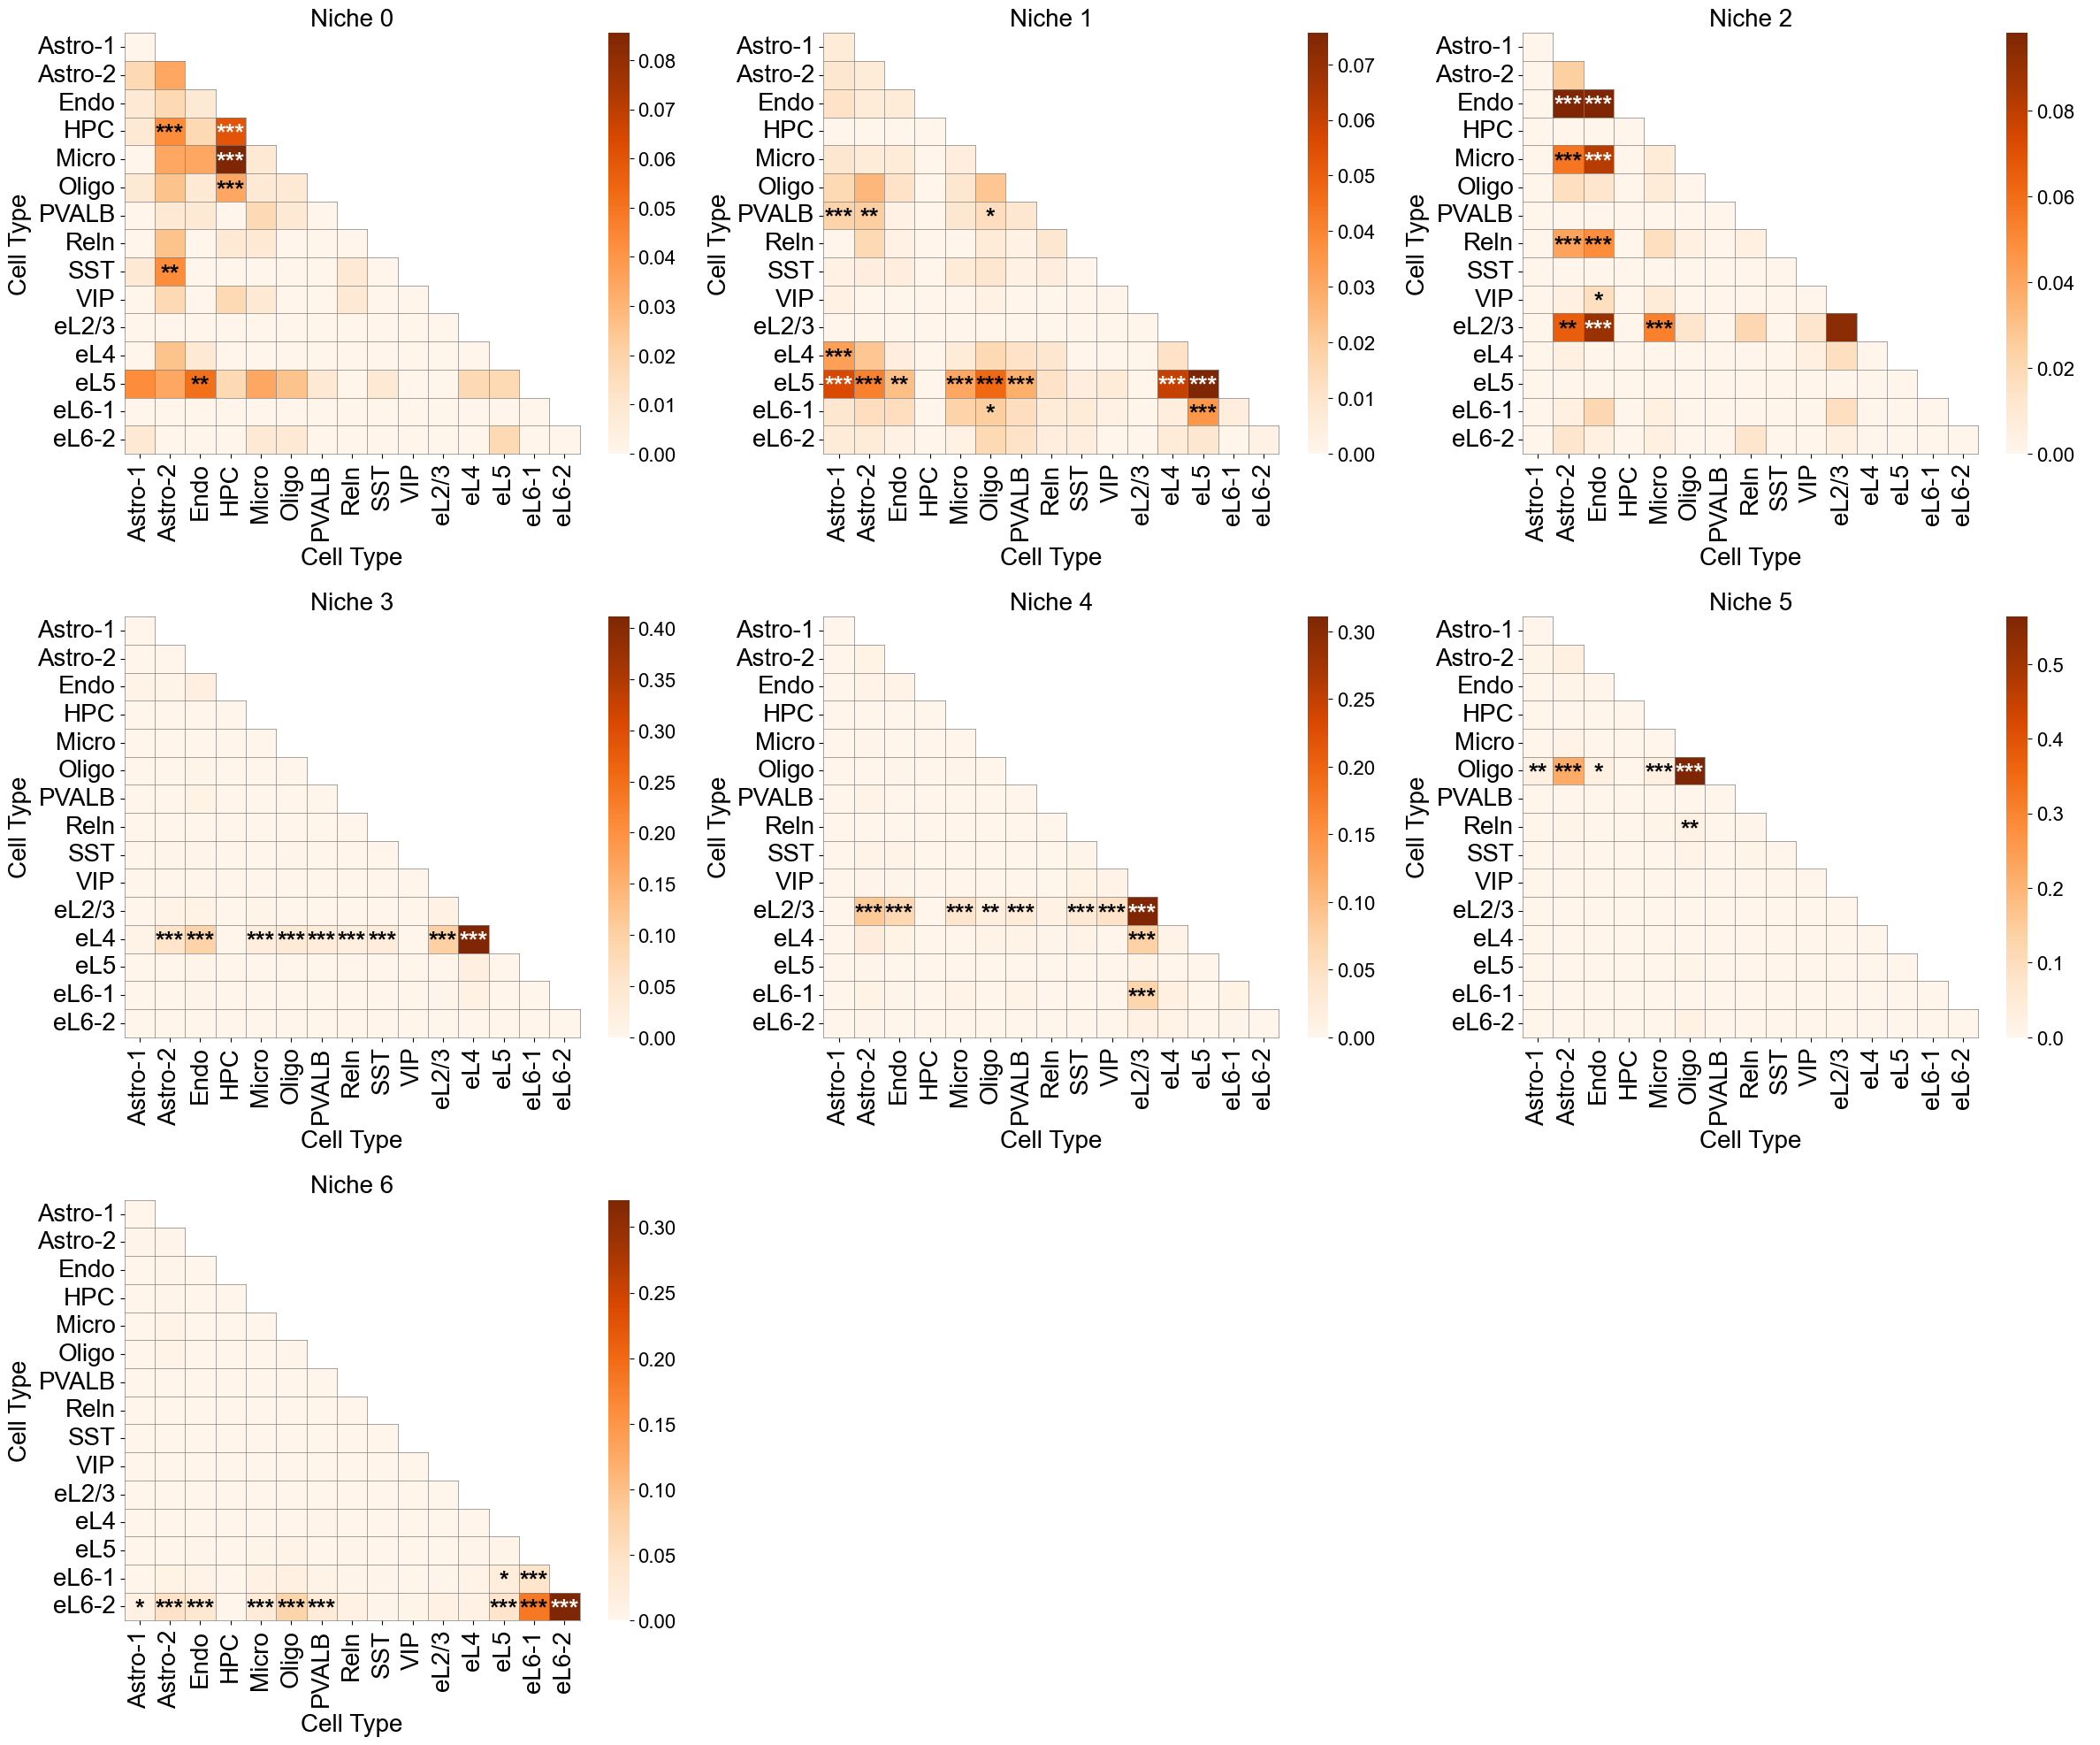

In [17]:
niche_labels = adata_new.uns['niche_label_summary'].copy()
ct_labels = sorted(adata_new.obs['celltype'].unique())

cci_df['stars'] = cci_df['q-value'].apply(p2stars)

figrows = 3
figcols = 3

fig, axes = plt.subplots(figrows, figcols, figsize=(24, 20))

for idx in range(figrows * figcols):

    imgrow = idx // figcols
    imgcol = idx % figcols

    if idx >= len(niche_labels):
        axes[imgrow, imgcol].axis('off')
        continue

    sub_df = cci_df[cci_df['niche_idx'] == idx]

    matrix_df = pd.DataFrame(
        data=test_norm_list[idx],
        index=ct_labels,
        columns=ct_labels,
    )

    for i in range(matrix_df.shape[0]):
        for j in range(matrix_df.shape[1]):
            if i < j:
                matrix_df.iloc[i, j] = np.nan

    stars_df = pd.DataFrame(
        '', 
        index=matrix_df.index, 
        columns=matrix_df.columns
    )

    for _, row in sub_df[sub_df['enrichment']].iterrows():
        ct1 = row['ct1']
        ct2 = row['ct2']
        if (ct1 in stars_df.index) and (ct2 in stars_df.columns):
            stars_df.loc[ct1, ct2] = row['stars']

    sns_heatmap = sns.heatmap(
        matrix_df, 
        cmap='Oranges', 
        mask=matrix_df.isna(),
        # cbar_kws={'label': 'Edge type proportion'}, 
        # linewidths=0.5,
        # linecolor='gray',
        # square=True,
        ax=axes[imgrow, imgcol],
    )

    n_rows, n_cols = matrix_df.shape

    for i, ct1 in enumerate(matrix_df.index):
        axes[imgrow, imgcol].plot([0, i+1], [i, i], color='gray', linewidth=0.5, clip_on=False) 
        axes[imgrow, imgcol].plot([i+1, i+1], [i, n_rows], color='gray', linewidth=0.5, clip_on=False)
        for j, ct2 in enumerate(matrix_df.columns):
            star = stars_df.iloc[i, j]
            if star:
                if matrix_df.iloc[i, j] > np.nanmax(matrix_df.values) * 0.7:
                    color='white'
                else:
                    color='black'
                axes[imgrow, imgcol].text(j + 0.5, i + 0.6, star, ha='center', va='center', color=color, fontsize=20, fontweight='bold')
    
    axes[imgrow, imgcol].plot([0, 0], [0, n_rows], color='gray', linewidth=0.5, clip_on=False) 
    axes[imgrow, imgcol].plot([0, n_cols], [n_rows, n_rows], color='gray', linewidth=0.5, clip_on=False)  
    # axes[imgrow, imgcol].plot([0, n_cols], [n_rows, n_rows], color='gray', linewidth=0.5, clip_on=False) 
    # axes[imgrow, imgcol].plot([n_cols, n_cols], [0, n_rows], color='gray', linewidth=0.5, clip_on=False)  

    axes[imgrow, imgcol].set_xticklabels(axes[imgrow, imgcol].get_xticklabels(), rotation=90, ha='center', fontsize=20)
    axes[imgrow, imgcol].set_yticklabels(axes[imgrow, imgcol].get_yticklabels(), rotation=0, ha='right', fontsize=20)
    axes[imgrow, imgcol].set_ylabel('Cell Type', fontsize=20)
    axes[imgrow, imgcol].set_xlabel('Cell Type', fontsize=20)
    axes[imgrow, imgcol].set_title(f'Niche {niche_labels[idx]}', fontsize=20)
    axes[imgrow, imgcol].collections[0].colorbar.ax.yaxis.label.set_size(20)
    axes[imgrow, imgcol].collections[0].colorbar.ax.tick_params(labelsize=16)
    axes[imgrow, imgcol].grid(False)

plt.tight_layout()
plt.show()

### Niche-niche co-localization analysis

In [18]:
nnc_results = nnc_enrichment_test(adata_new, 
                                  'niche_label', 
                                  niche_summary=adata_new.uns['niche_label_summary'],  
                                  spatial_key='spatial', 
                                  cut_percentage=99, 
                                  method='fisher', 
                                  alpha=0.05, 
                                  fdr_method='fdr_by', 
                                  log2fc_threshold=1, 
                                  prop_threshold=0.01,
                                  verbose=True,
                                  )
nnc_df, edge_prop_mtx, n1_count = nnc_results
nnc_df.head()

7 niches in total.



,niche1_idx,niche1,niche2_idx,niche2,edge_count,edge_prop,oddsratio,p-value,q-value,log2fc,enrichment
0,0,0,1,1,0.0,0.0,0.0,1.915542e-04,9.160483e-04,-30.636632,False
1,0,0,2,2,0.0,0.0,0.0,6.299259e-03,2.725527e-02,-30.023655,False
2,0,0,3,3,0.0,0.0,0.0,6.398166e-05,3.229709e-04,-30.806557,False
3,0,0,4,4,0.0,0.0,0.0,2.105132e-05,1.125151e-04,-30.936193,False
4,0,0,5,5,51.0,1.0,inf,1.786022e-47,8.114042e-46,3.528201,True


Plot the results

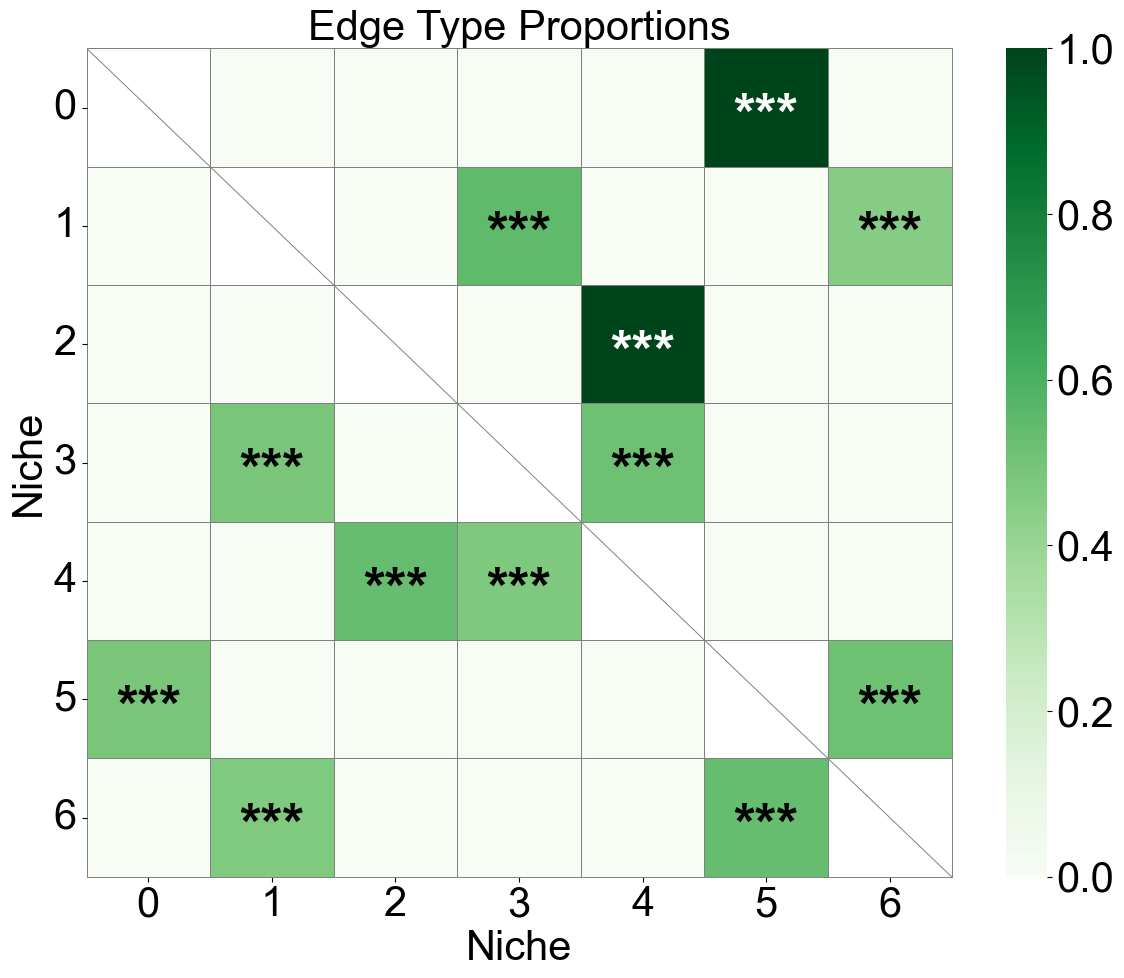

In [19]:
niche_labels = adata_new.uns['niche_label_summary'].copy()

nnc_df['stars'] = nnc_df['q-value'].apply(p2stars)

matrix_df = pd.DataFrame(
    data=edge_prop_mtx,
    index=niche_labels,
    columns=niche_labels,
)

for i in range(matrix_df.shape[0]):
    for j in range(matrix_df.shape[1]):
        if i == j:
            matrix_df.iloc[i, j] = np.nan

stars_df = pd.DataFrame(
    '', 
    index=matrix_df.index, 
    columns=matrix_df.columns
)

for _, row in nnc_df[nnc_df['enrichment']].iterrows():
    n1 = row['niche1']
    n2 = row['niche2']
    if (n1 in stars_df.index) and (n2 in stars_df.columns):
        stars_df.loc[n1, n2] = row['stars']

plt.figure(figsize=(12, 10))

ax  = sns.heatmap(
    matrix_df, 
    cmap='Greens', 
    # cbar_kws={'label': 'Edge type proportion'}, 
    linewidths=0.7,
    linecolor='gray',
    # square=True,
)

for i, n1 in enumerate(matrix_df.index):
    for j, n2 in enumerate(matrix_df.columns):
        if i == j:
            ax.plot([i, i+1], [i, i+1], color='gray', linewidth=0.7)
            # ax.plot([i+1, i], [i, i+1], color='gray', linewidth=0.7)
            continue
        star = stars_df.iloc[i, j]
        if star:
            if matrix_df.iloc[i, j] > np.nanmax(matrix_df.values) * 0.7:
                color='white'
            else:
                color='black'
            ax.text(j + 0.5, i + 0.6, star, ha='center', va='center', color=color, fontsize=40, fontweight='bold')

n_rows, n_cols = matrix_df.shape
ax.plot([0, n_cols], [n_rows, n_rows], color='gray', linewidth=0.7, clip_on=False) 
ax.plot([n_cols, n_cols], [0, n_rows], color='gray', linewidth=0.7, clip_on=False)  

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=30)
ax.set_ylabel('Niche', fontsize=30)
ax.set_xlabel('Niche', fontsize=30)
ax.set_title('Edge Type Proportions', fontsize=30)
ax.collections[0].colorbar.ax.yaxis.label.set_size(30)
ax.collections[0].colorbar.ax.tick_params(labelsize=30)
ax.grid(False)

plt.tight_layout()
plt.show()

### Reload the data
keep the smooth muscle cells and see whether they can be separate from layer 1

In [ ]:
slice_name_list = ['V1']
adata = ad.read_h5ad(data_dir + 'processed/STARmap_V1Cortex.h5ad')
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'clusterid', 'celltype', 'layer'
    obsm: 'spatial'

### Run model

Instantiate Harmonics

In [ ]:
iter=0
model = Harmonics_Model(adata,  # anndata object with cell type and spatial coordinates information
                        slice_name_list,  # list of slice names (only one slice here)
                        concat_label='slice_name',  # the label in .obs to store slice names
                        seed=1234+iter,  # default
                        parallel=False,  # recommand to set to True for large dataset and False for small dataset
                        verbose=True,  # default
                        )

Dataset comprises 1 slices, 1207 cells/spots in total.


Preprocess the data (Generating the connection graph and calculating neighborhood cell type destribution for cells)

In [ ]:
model.preprocess(ct_key='celltype',  # the label in .obs to indicate cell types
                 spatial_key='spatial',  # default
                 method='joint',  # default
                 n_step=3,  # default
                 n_neighbors=20,  # default
                 cut_percentage=99,  # default
                 )

Generating Delaunay neighbor graph...


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


All done!

Performing graph completion...


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


All done!

The cell types of interest are:
Astro-1
Astro-2
Endo
HPC
Micro
Oligo
PVALB
Reln
SST
Smc
VIP
eL2/3
eL4
eL5
eL6-1
eL6-2

Generating one-hot matrix...


100%|██████████| 1/1 [00:00<00:00, 500.63it/s]

All done!

Dataset comprises 16 cell types.

Calculating cell type distribution for microenvironments...
Microenvironments comprise 39.99 cells/spots on average. 
Minimum: 20, Maximum: 62



Perform overclustered initialization on the cell type distributions of cell neighborhoods. Resulting in *Qmax* niches. The distributions of niches are also computed. We set *Qmax* to 10 since this is a relatively small dataset.

In [ ]:
model.initialize_clusters(dim_reduction=True,  # default
                          explained_var=None,  # default
                          n_components=None,  # default
                          n_components_max=100,  # default
                          standardize=True,  # default
                          method='kmeans',  # default 
                          Qmax=10, 
                          )

Performing dimension reduction...
Returning 16 principal components.

Initializing niches...
10 initial niches defined.



Perform hierarchical distribution matching to reduce the niche number to no more than *Qmin*. This step results in niche assignment under a sequence of different niche numbers (usually from *Qmax* to *Qmin*).

In [ ]:
model.hier_dist_match(assign_metric='jsd',  # default
                      weighted_merge=True,  # default
                      max_iters=100,  # default 
                      tol=1e-4,  # default 
                      test_kmeans=False,  # default
                      Qmin=2,  # default
                      )

Starting from 10 cell niches...

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 305.68it/s]


Early stop because of duplicate reassignment at iteration 25.
9 cell niches left.
Merging cell niche 2 and cell niche 6...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 8, 9]


  4%|▍         | 4/100 [00:00<00:00, 333.33it/s]


Strictly converge at iteration 5.
8 cell niches left.
Merging cell niche 3 and cell niche 9...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 2, 3, 4, 5, 8]


  4%|▍         | 4/100 [00:00<00:00, 307.69it/s]


Strictly converge at iteration 5.
7 cell niches left.
Merging cell niche 5 and cell niche 2...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 3, 4, 5, 8]


  1%|          | 1/100 [00:00<00:00, 142.84it/s]


Strictly converge at iteration 2.
6 cell niches left.
Merging cell niche 5 and cell niche 8...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 3, 4, 5]


  2%|▏         | 2/100 [00:00<00:00, 222.20it/s]


Strictly converge at iteration 3.
5 cell niches left.
Merging cell niche 4 and cell niche 3...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 4, 5]


 10%|█         | 10/100 [00:00<00:00, 425.31it/s]

Strictly converge at iteration 11.


4 cell niches left.
Merging cell niche 1 and cell niche 5...
Done!

Assigning cells to cell niche...
Current state: [0, 1, 4]


 15%|█▌        | 15/100 [00:00<00:00, 405.40it/s]


Strictly converge at iteration 16.
3 cell niches left.
Merging cell niche 0 and cell niche 4...
Done!

Assigning cells to cell niche...
Current state: [0, 1]


  7%|▋         | 7/100 [00:00<00:00, 411.73it/s]

Strictly converge at iteration 8.
2 cell niches left.
Niche count no more than 2.

Finished!



### Automatically detect the optimal number of niches
n_niche can be set to 8 in order to get the smooth muscle niche if the optimal number is not automatically decided to be 8 by Harmonics  
since the dataset is relatively small, it cannot be guaranteed to find 8 as the optimal number of niches

Automatically selecting best solution...
Recommended number of niches are [8]
Selecting 8 niches as the best solution.


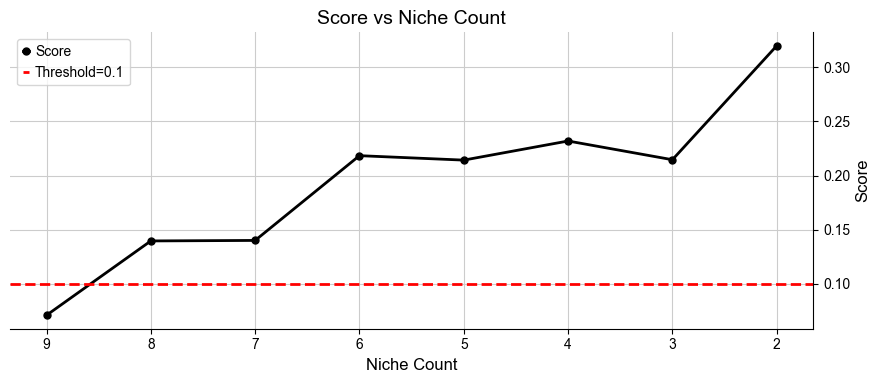

Done!



In [ ]:
adata_list, adata_concat = model.select_solution(n_niche=None,  # default
                                                 niche_key='niche_label',  # default 
                                                 auto=True,  # default 
                                                 metric='jsd',  # default
                                                 threshold=0.1,  # default
                                                 return_adata=True,  # default
                                                 plot=True,  # default
                                                 save=False,  # default
                                                 fig_size=None,  # default
                                                 save_dir=save_dir, 
                                                 file_name=f'unfiltered_score_vs_nichecount_basic_{iter}.pdf',
                                                 )

Save and reload the results

In [ ]:
adata_concat.write_h5ad(save_dir + f'unfiltered_Harmonics_result_{iter}.h5ad')

In [ ]:
adata_concat = ad.read_h5ad(save_dir + f'unfiltered_Harmonics_result_{iter}.h5ad')
adata_new = adata_concat.copy()
adata_new

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'clusterid', 'celltype', 'layer', 'slice_name', 'celltype_idx', 'n_neighbors', 'niche_label'
    uns: 'ct2idx', 'idx2ct', 'niche_label_summary', 'niche_dist', 'niche_cell_count'
    obsm: 'spatial', 'onehot', 'micro_dist'

### Plot the results

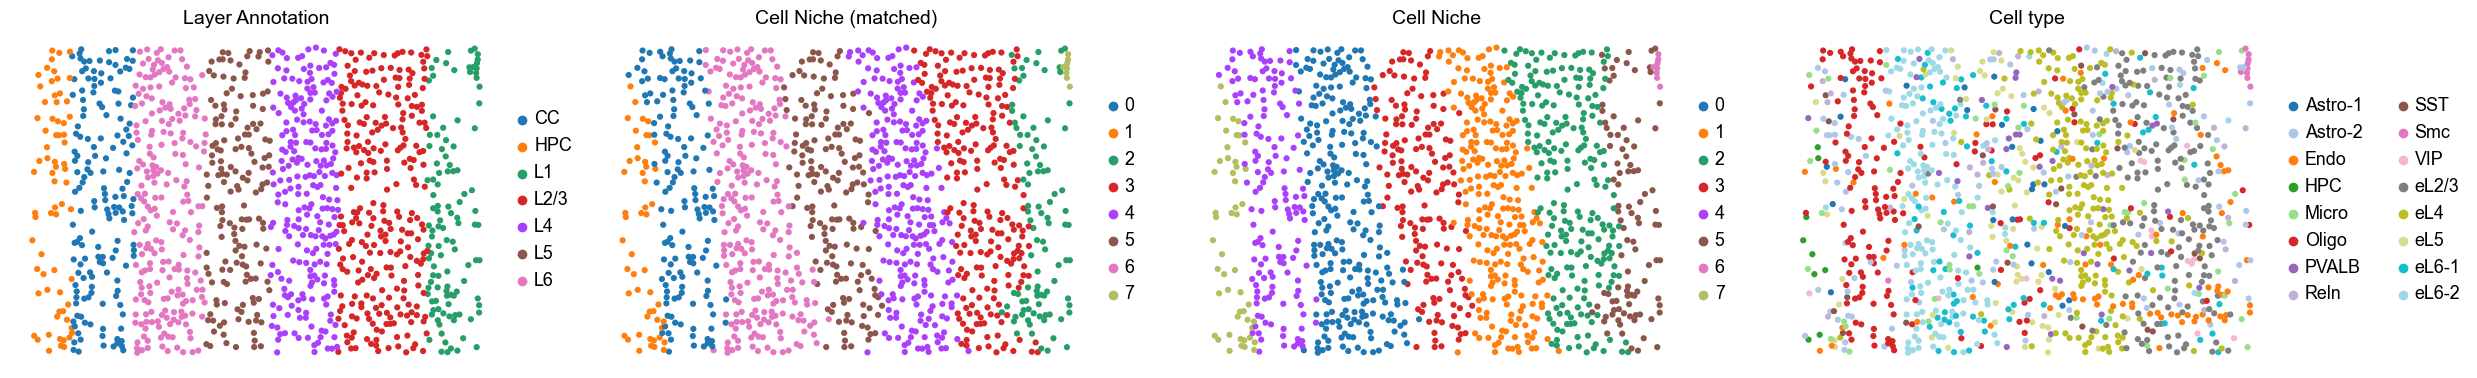

In [ ]:
layers = sorted(set(adata_new.obs['layer']))
layer_color_dict = {layers[k]: sns.color_palette()[k] for k in range(len(layers))}

niches = sorted(set(adata_new.obs['niche_label']))
niche_color_dict = {niches[k]: sns.color_palette()[k] for k in range(len(niches))}

celltypes = ['Astro-1', 'Astro-2', 'Endo', 'HPC', 'Micro', 'Oligo', 'PVALB', 'Reln', 
             'SST', 'Smc', 'VIP', 'eL2/3', 'eL4', 'eL5', 'eL6-1', 'eL6-2']
ct_colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#2ca02c', '#98df8a', '#d62728', '#9467bd', '#c5b0d5',
             '#8c564b', '#e377c2', '#f7b6d2', '#7f7f7f', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
ct_color_dict = {celltypes[k]: ct_colors[k] for k in range(len(celltypes))}


matched_clusters = match_cluster_labels(adata_new.obs['layer'], adata_new.obs[f'niche_label'])
matched_labels = [layers[idx] if idx < len(layers) else 'Unmatched' for idx in matched_clusters]
adata_new.obs[f'matched_cluster'] = [str(label) for label in matched_clusters]
adata_new.obs[f'matched_label'] = matched_labels


fig, axes = plt.subplots(1, 4, figsize=(25, 4))

sc.pl.embedding(adata_new, basis='spatial', palette=layer_color_dict, color='layer', 
                ax=axes[0], s=80, show=False, frameon=False, title='Layer Annotation')

sc.pl.embedding(adata_new, basis='spatial', palette=niche_color_dict, color='matched_cluster', 
                ax=axes[1], s=80, show=False, frameon=False, title='Cell Niche (matched)')

sc.pl.embedding(adata_new, basis='spatial', palette=niche_color_dict, color='niche_label', 
                ax=axes[2], s=80, show=False, frameon=False, title='Cell Niche')

sc.pl.embedding(adata_new, basis='spatial', palette=ct_color_dict, color='celltype', 
                ax=axes[3], s=80, show=False, frameon=False, title='Cell type')

plt.tight_layout()
plt.show()